In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import optimize

import constants as const

plt.style.use('science')

In [2]:
lo = np.loadtxt('spectra_local_lo_a0_fix_hpp_n_14.txt')
nlo = np.loadtxt('spectra_local_nlo_a0_B6_fix_coord_hp_n_14_coord_ir_corrected_R4.txt')
mm = np.loadtxt('spectra_Mott_Massey.txt')

In [3]:
1/np.sqrt(2*const.MU*-mm)

array([0.18020035, 0.21805488, 0.27700042, 0.37871962, 0.5863641 ,
       1.15983366, 4.18239303])

In [4]:
def convergence(lamb, c1, c2):
    return c1 * (1 + c2*(1/lamb))


def convergence_improved(lamb, c1, c2, q):
    return c1 * (1 + c2*(q/lamb))

In [5]:
gamma_mm = np.sqrt(2*const.MU*-mm)

| n=0 | -0.1129 |
| n=1 | -0.1092 |
| n=2 | -0.1003 |
| n=3 | -0.0863 |
| n=4 | -0.0686 |
| n=5 | -0.0496 |
| n=6 | -0.0446 |


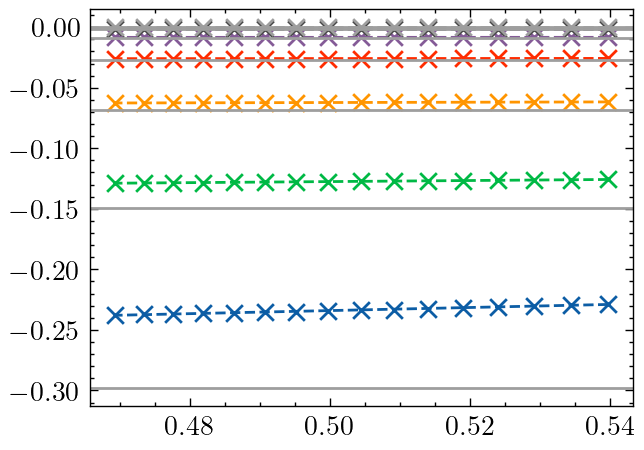

In [6]:
R_lo = lo[:, 0]
x_lo = const.BETA4 / R_lo
energies_lo = lo[:, 1:].T
c1_tilde_lo = []

ii = np.intersect1d(
    np.where(x_lo > 60)[0],
    np.where(x_lo < 70)[0]
)

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

lo_asymp = []

for (i, row) in enumerate(energies_lo):
    gamma = np.sqrt(2*const.MU*-row[-1])
    pars, cov = optimize.curve_fit(lambda x, c1, c2: convergence(x, c1, c2), 
                                   x_lo[ii], row[ii])
#     print(pars)
    c1_tilde_lo.append(pars[1] / (const.BETA4*np.sqrt(2*const.MU*-pars[0])/np.pi))
    print(f'| n={i} | {pars[1] / (const.BETA4*np.sqrt(2*const.MU*-pars[0])/np.pi):.4f} |')
    lo_asymp.append(pars[0])
    
    ax.scatter(const.BETA4/x_lo[ii], row[ii], color=f'C{i}', marker='x')
    ax.plot(const.BETA4/x_lo[ii], convergence(x_lo[ii], *pars), linestyle='--', color=f'C{i}')
    ax.axhline(pars[0], color='C6')

## NLO Quadratic

In [7]:
b_lo = -energies_lo[:, ii]
b_lo.shape

(7, 16)

In [8]:
gamma_6 = np.sqrt(2*const.MU*-row[-1])

In [9]:
lower_bounds = [
    -np.inf,
    -50,
    -100
]

upper_bounds = [
    np.inf,
    50,
    100
]

bounds = optimize.Bounds(lower_bounds, upper_bounds)

In [10]:
def convergence2(lamb, c1, c2):
    return c1 * (1 + c2*(1/lamb)**2)


def convergence12(lamb, c1, c2, c3):
    return c1 * (1 + c2/lamb + c3/lamb**4)


def convergence_linear_quadratic(lamb, c1, c2, c3):
    return c1 * (1 + c2/lamb + c3/lamb**2)


def convergence12_improved(lamb, c1, c2, c3, q):
    return c1 * (1 + c2*(q/lamb) + c3*(q/lamb)**2)


def convergence_124(lamb, c1, c2, c3, c4):
    return c1 * (1 + c2/lamb + c3/lamb**2 + c4/lamb**4)

In [11]:
R_nlo = nlo[:, 0]
x_nlo = const.BETA4 / R_nlo
energies_nlo = -nlo[:, 1:].T

ii = np.intersect1d(
    np.where(x_nlo > 60)[0],
    np.where(x_nlo < 70)[0]
)

b_nlo = energies_nlo[:, ii]
b_nlo.shape

(7, 15)

In [12]:
gamma_mm

array([5.54937872, 4.58600143, 3.61010279, 2.64047583, 1.70542502,
       0.8621926 , 0.23909757])

-0.7286 | 0.0823
-0.6257 | 0.1598
-0.3964 | 0.2942
-0.1886 | 0.5314
-0.0613 | 0.9786
-0.0086 | 1.7815
0.0000 | -0.0754


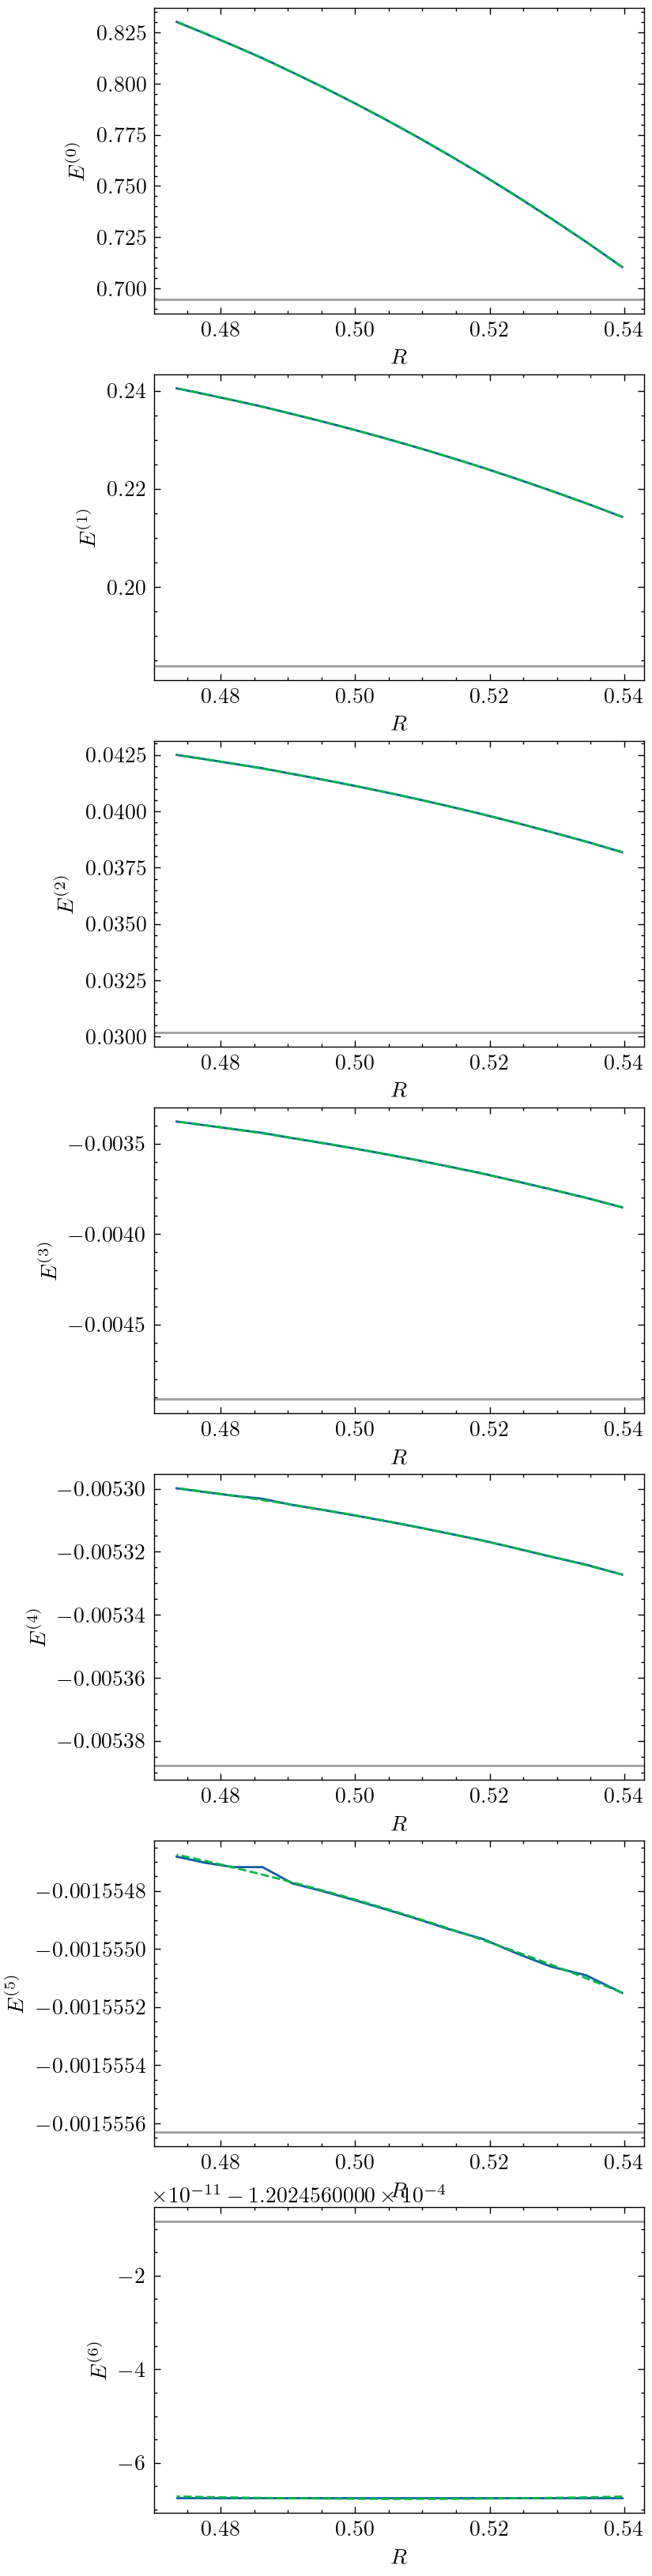

In [37]:
f = convergence12
num_coeffs = 2

fit_values = []
nlo_asymp = []
c1_tilde_nlo = []
c4_tilde_nlo = []

fig, ax = plt.subplots(7, figsize=(4, 7*3), dpi=200)
fig.patch.set_facecolor('white')

first = True
for (i, row) in enumerate(energies_nlo[:, ii]):
#     if first:
#         guess = [row[-1], -0.1]
#     if np.any(row > 0):
#         row *= -1
#     pars, cov = optimize.curve_fit(convergence2, x_nlo[ii], row, p0=guess, maxfev=10000)
    
#     if first:
#         guess = [row[-1], -0.01, 1]
#     if np.any(row > 0):
#         row *= -1
    
    converged = False
    while not converged:
        guess = [row[-1]] + num_coeffs*[10*np.random.rand()-5]
#         guess = [row[-1], 10*np.random.rand()-5, 10*np.random.rand()-5, 10*np.random.rand()-5]
#         guess = [row[-1], 10*np.random.rand()-5, 10*np.random.rand()-5]
#         guess = [row[-1], 10*np.random.rand()-5]
        pars, cov, infodict, msg, ier = optimize.curve_fit(
            f, x_nlo[ii], row, p0=guess, maxfev=1000000, full_output=True,
            sigma=0.1*np.abs(np.mean(row))*np.ones(row.size)
        )
        err = np.sqrt(np.sum(np.array(infodict['fvec'])**2))
        converged = err < 1
#         print(guess, err)
        os.system('clear')
    
    fit_values.append(pars)
    first = False
    sigma = np.sqrt(np.diag(cov))
    guess = pars
#     print(f'{row[-1]:.2e} | {pars[0]:2e} ± {sigma[0]:.2e}')
#     print(f'E_{i}', pars, pars[0]*pars[1] / (const.BETA4*gamma_mm[i]))
    gamma_i = np.sqrt(2*const.MU*-lo_asymp[i])
    
    temp = pars[0] / lo_asymp[i] * pars[1] / (const.BETA4*gamma_i/np.pi)
    c1_tilde_nlo.append(temp)
    
    temp4 = pars[0] / lo_asymp[i] * pars[2] / (const.BETA4*gamma_i/np.pi)**4
    c4_tilde_nlo.append(temp4)
    
    print(f'{temp:.4f} | {temp4:.4f}')
    
    nlo_asymp.append(pars[0])
    ax[i].plot(const.BETA4/x_nlo[ii], row)
    
    xp = np.linspace(x_nlo[ii][0], 1*x_nlo[ii][-1], 100)
    ax[i].plot(const.BETA4/xp, f(xp, *pars), linestyle='--')
    
    ax[i].axhline(pars[0], color='C6')
    
    ax[i].set_xlabel(r'$R$')
    ax[i].set_ylabel(r'$E^{(%d)}$' % (i))
#     ax[i].set_yscale('log');

In [38]:
gamma_mm[0] / gamma_mm[-2]

6.4363562151766995

In [39]:
print('| n | LO(c_1) | NLO(c_1)| NLO (c_4) |')
print('| - | --      | ------- | --------- |')
for (i, (x, y, z)) in enumerate(zip(c1_tilde_lo, c1_tilde_nlo, c4_tilde_nlo)):
    print(f'| {i} | {x:.4f} | {y:.4f} | {z:.4f} |')

| n | LO(c_1) | NLO(c_1)| NLO (c_4) |
| - | --      | ------- | --------- |
| 0 | -0.1129 | -0.7286 | 0.0823 |
| 1 | -0.1092 | -0.6257 | 0.1598 |
| 2 | -0.1003 | -0.3964 | 0.2942 |
| 3 | -0.0863 | -0.1886 | 0.5314 |
| 4 | -0.0686 | -0.0613 | 0.9786 |
| 5 | -0.0496 | -0.0086 | 1.7815 |
| 6 | -0.0446 | 0.0000 | -0.0754 |


In [40]:
lo_asymp

[-0.29767352176813383,
 -0.14939242753297324,
 -0.06844563750453793,
 -0.027249829468125975,
 -0.008593936571172708,
 -0.0017481734997854684,
 -0.00011935922586892024]

In [41]:
energies_nlo[3:4, ii]

array([[-0.00385249, -0.00379954, -0.00375337, -0.00370837, -0.00366572,
        -0.00362761, -0.00359151, -0.00355789, -0.00352655, -0.00349732,
        -0.00347016, -0.0034412 , -0.00342032, -0.00339903, -0.00337835]])

In [42]:
energies_nlo[4, ii]

array([-0.00532728, -0.00532411, -0.0053216 , -0.00531898, -0.00531643,
       -0.00531428, -0.00531219, -0.00531024, -0.00530843, -0.00530674,
       -0.00530518, -0.00530321, -0.00530224, -0.00530108, -0.00529989])

-0.0613 | 0.9786 		RMS(14) =  4.974137078983661e-07
-0.3324 | 0.6244 		RMS(12) =  4.869609351001729e-07
-0.4497 | 0.8946 | -0.4239 	RMS(124) =  4.858933957267187e-07


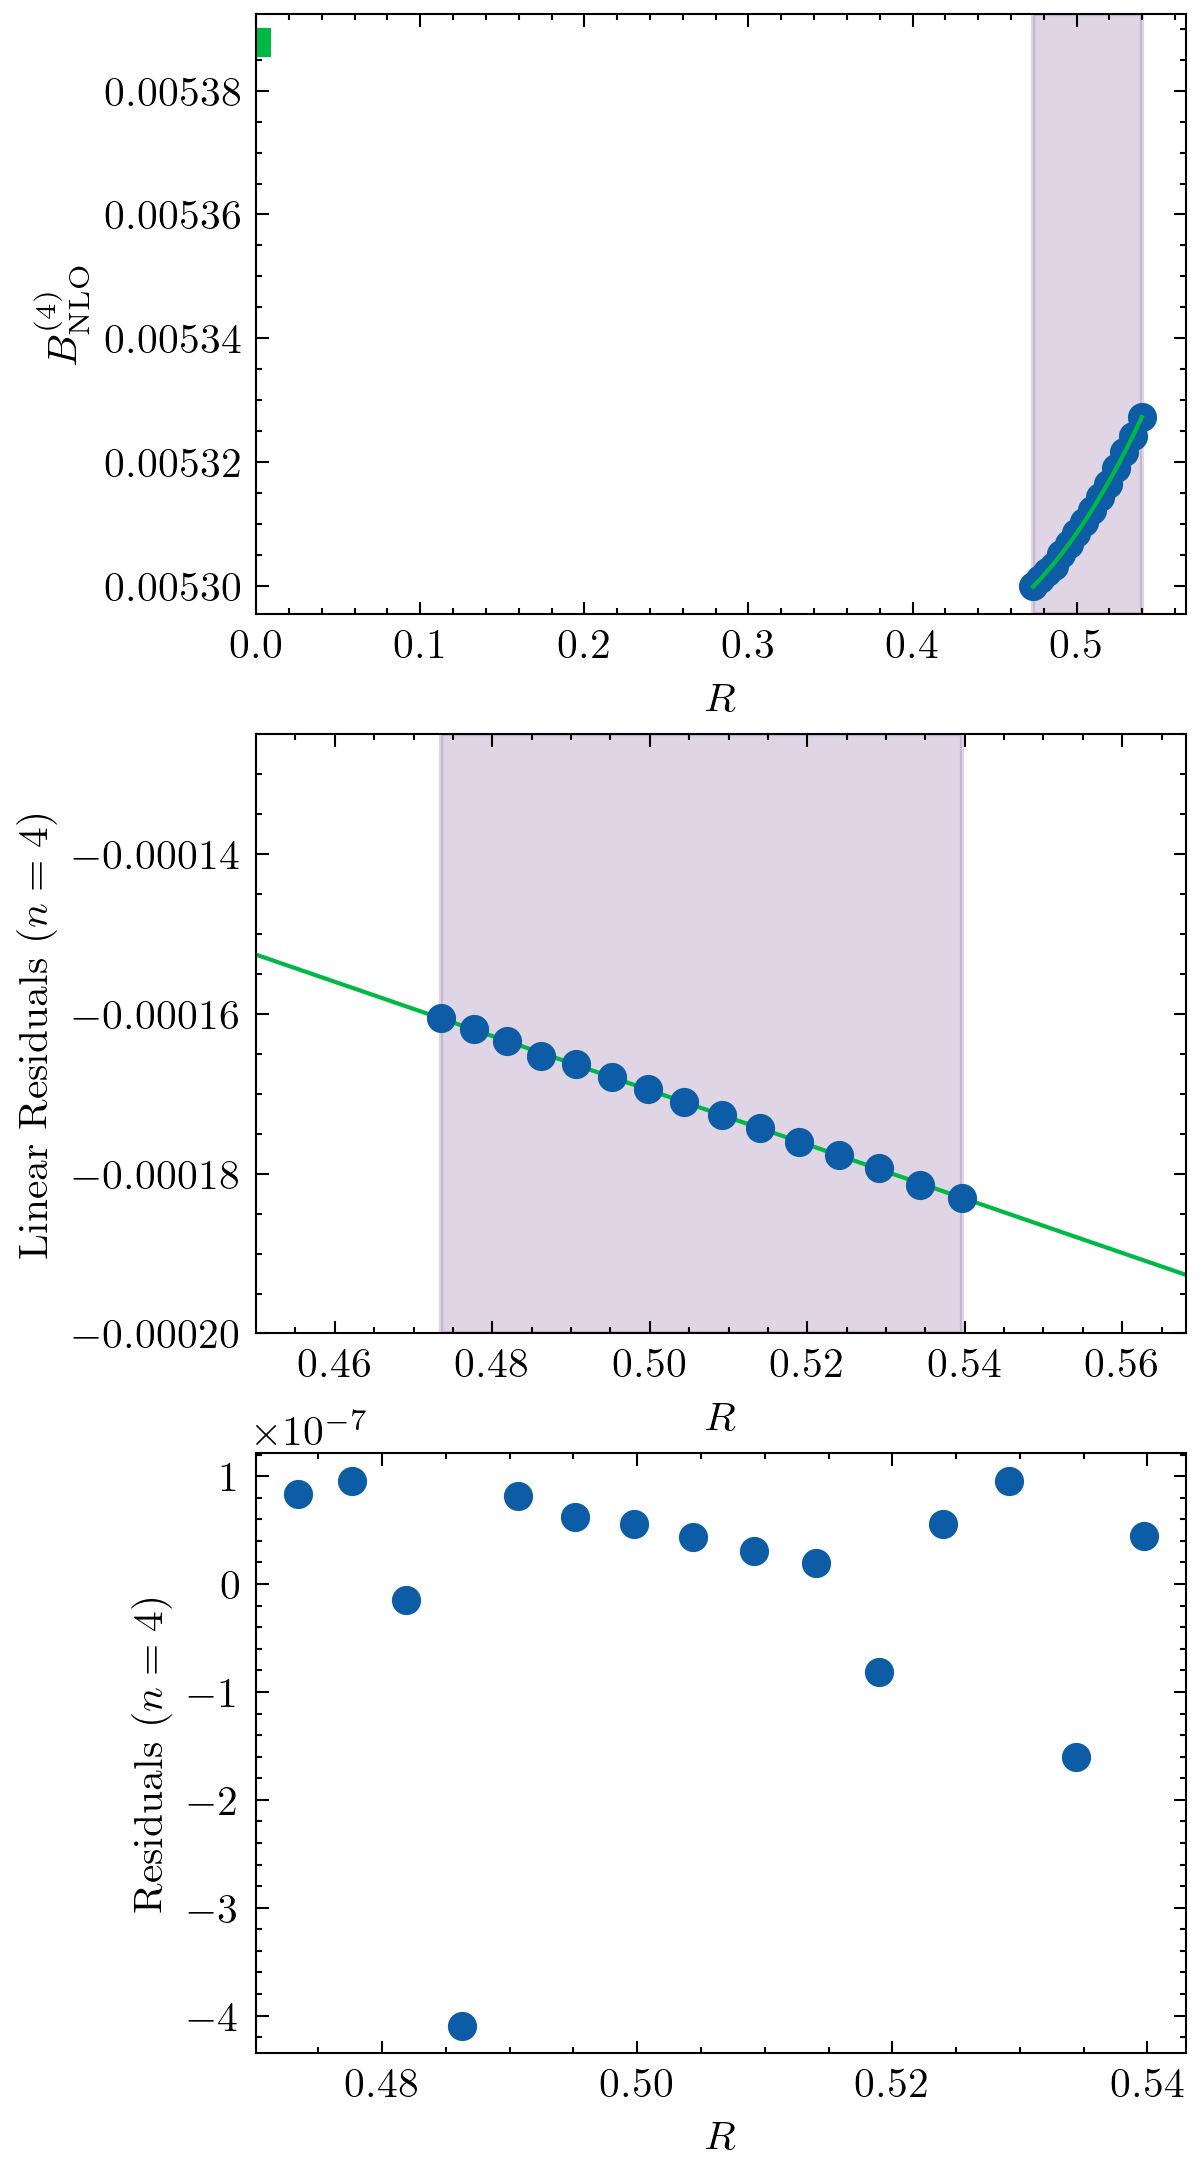

In [43]:
x = x_nlo[ii]

fig, ax = plt.subplots(3, figsize=(4, 3*3), dpi=300)
fig.patch.set_facecolor('white')

i = 4
for row in energies_nlo[i:i+1, ii]:
    
    ax[0].axvspan(const.BETA4/x_nlo[ii][0], const.BETA4/x_nlo[ii][-1], color='C4', alpha=0.25)
#     ax[0].axhline(-lo_asymp[i], color='C0', linestyle='-')
#     ax[0].axhline(-mm[i], color='C6', linestyle=':')

    #
    # R + R^4
    #
    converged = False
    while not converged:
        guess = [row[-1], 10*np.random.rand()-5, 10*np.random.rand()-5]
        pars, cov, infodict, msg, ier = optimize.curve_fit(
            lambda x, c1, c2, c3: convergence12(x, c1, c2, c3), 
            x_nlo[ii], row, p0=guess, maxfev=100000, full_output=True,
            sigma=0.1*np.abs(np.mean(row))*np.ones(row.size)
        )
        err = np.sqrt(np.sum(np.array(infodict['fvec'])**2))
        converged = err < 1
    
    gamma_i = np.sqrt(2*const.MU*-lo_asymp[i])
    
    temp = pars[0] / lo_asymp[i] * pars[1] / (const.BETA4*gamma_i/np.pi)
    temp4 = pars[0] / lo_asymp[i] * pars[2] / (const.BETA4*gamma_i/np.pi)**4
    
    y = -row
    mu14 = -convergence12(x_nlo[ii], *pars)
    
    ax[0].plot(const.BETA4/xp, -convergence12(xp, *pars), linestyle='-', color='C1')
    ax[0].scatter(const.BETA4/x, y, marker='o', color='C0')
#     ax[0].axhline(-pars[0], color='C0', linestyle='-')
    ax[0].plot(0, -pars[0], color='C1', marker='s')
    print(f'{temp:.4f} | {temp4:.4f}', '\t\tRMS(14) = ', np.sqrt(np.sum((y - mu14)**2)))
    
    xp = np.linspace(0.95*x_nlo[ii][0], 5*x_nlo[ii][-1], 100)
    ax[1].plot(const.BETA4/xp, -convergence12(xp, *pars) + pars[0]  + pars[0]*pars[2]/xp**4,
               linestyle='-', color='C1', label=r'$R+R^4$')
    ax[1].plot(const.BETA4/x, y + pars[0]  + pars[0]*pars[2]/x**4,
               linestyle='', marker='o', color='C0', label=r'$R+R^4$')
    
    ax[2].scatter(const.BETA4/x, y + convergence12(x, *pars))
    
    #
    # R + R^2
    #
    converged = False
    while not converged:
        guess = [row[-1], 10*np.random.rand()-5, 10*np.random.rand()-5]
        pars, cov, infodict, msg, ier = optimize.curve_fit(
            lambda x, c1, c2, c3: convergence_linear_quadratic(x, c1, c2, c3),
            x_nlo[ii], row, p0=guess, maxfev=100000, full_output=True,
            sigma=0.1*np.abs(np.mean(row))*np.ones(row.size)
        )
        err = np.sqrt(np.sum(np.array(infodict['fvec'])**2))
        converged = err < 1
    
    temp = pars[0] / lo_asymp[i] * pars[1] / (const.BETA4*gamma_i/np.pi)
    temp2 = pars[0] / lo_asymp[i] * pars[2] / (const.BETA4*gamma_i/np.pi)**2
#     print(f'{temp:.4f} | {temp2:.4f}')
    
    mu12 = -convergence_linear_quadratic(x_nlo[ii], *pars)
#     ax[0].plot(const.BETA4/xp, -convergence_linear_quadratic(xp, *pars), linestyle='--', color='C1')
#     ax[0].axhline(-pars[0], color='C1', linestyle='--')
    print(f'{temp:.4f} | {temp2:.4f}', '\t\tRMS(12) = ', np.sqrt(np.sum((y - mu12)**2)), end='\n')
    
#     ax[1].plot(const.BETA4/x, -convergence_linear_quadratic(x, *pars) + pars[0]  + pars[0]*pars[2]/x**2,
#                linestyle='--', color='C1', label=r'$R+R^2$')
    
    #
    # R + R^2 + R^4
    #
    converged = False
    while not converged:
        guess = [row[-1], 10*np.random.rand()-5, 10*np.random.rand()-5, 10*np.random.rand()-5]
        pars, cov, infodict, msg, ier = optimize.curve_fit(
            lambda x, c1, c2, c3, c4: convergence_124(x, c1, c2, c3, c4),
            x_nlo[ii], row, p0=guess, maxfev=1000000, full_output=True,
            sigma=0.1*np.abs(np.mean(row))*np.ones(row.size)
        )
        err = np.sqrt(np.sum(np.array(infodict['fvec'])**2))
        converged = err < 1
    
    temp = pars[0] / lo_asymp[i] * pars[1] / (const.BETA4*gamma_i/np.pi)
    temp2 = pars[0] / lo_asymp[i] * pars[2] / (const.BETA4*gamma_i/np.pi)**2
    temp4 = pars[0] / lo_asymp[i] * pars[3] / (const.BETA4*gamma_i/np.pi)**4
#     print(f'{temp:.4f} | {temp2:.4f} | {temp4:.4f}')
    
    mu124 = -convergence_124(x_nlo[ii], *pars)
#     ax[0].plot(const.BETA4/xp, -convergence_124(xp, *pars), linestyle='-.', color='C2')
#     ax[0].axhline(-pars[0], color='C2', linestyle='-.')
    print(f'{temp:.4f} | {temp2:.4f} | {temp4:.4f}', '\tRMS(124) = ', np.sqrt(np.sum((y - mu124)**2)), end='\n')
    
#     ax[1].plot(const.BETA4/x, -convergence_124(x, *pars) + pars[0] + pars[0]*pars[2]/x**2 + pars[0]*pars[3]/x**4,
#                linestyle='-.', color='C2', label=r'$R+R^2+R^4$')
#     ax[1].plot(const.BETA4/xp, -lo_asymp[i] + c1_tilde_lo[i]*(gamma_i*np.pi/xp/const.BETA4),
#                linestyle=':', color='C3')
    
ax[0].set_xlabel(r'$R$')
# ax[0].set_xticklabels([])
ax[0].set_ylabel(r'$B^{(%d)}_{\rm NLO}$' % (i))
xlim = ax[0].get_xlim()
ax[0].set_xlim((0, xlim[1]))

ax[1].set_xlim([0.45, const.BETA4/xp[0]])
ax[1].set_ylim([-2e-4, -1.25e-4])
ax[1].axvspan(const.BETA4/x_nlo[ii][0], const.BETA4/x_nlo[ii][-1], color='C4', alpha=0.25)
# ax[1].legend()
ax[1].set_ylabel(r'Linear Residuals ($n=%d$)' % (i))
ax[1].set_xlabel(r'$R$')

ax[2].set_ylabel(r'Residuals ($n=%d$)' % (i))
ax[2].set_xlabel(r'$R$');

# plt.subplots_adjust(hspace=0);

# plt.savefig('figures/fit_14.pdf')

| n | LO      | NLO     |
| - | --      | ---     |
| 0 | -0.1129 | -0.7286 |
| 1 | -0.1092 | -0.6257 |
| 2 | -0.1003 | -0.3964 |
| 3 | -0.0863 | -0.1886 |
| 4 | -0.0686 | -0.0613 |
| 5 | -0.0496 | -0.0086 |
| 6 | -0.0446 | -0.0000 |


[ 6.94532035e-01  3.86831344e+01 -8.30421328e+06]
[ 1.83898142e-01  4.46031028e+01 -7.69891695e+06]
[ 3.01782691e-02  5.34003845e+01 -8.30595638e+06]
[-4.91178092e-03 -3.92139757e+01  5.81807084e+06]
[-5.38793324e-03 -2.05894070e+00  3.06352694e+05]
[-1.55563098e-03 -9.17609856e-02  1.62581668e+04]
[-1.20245727e-04 -4.25891580e-05  2.86455286e+00]


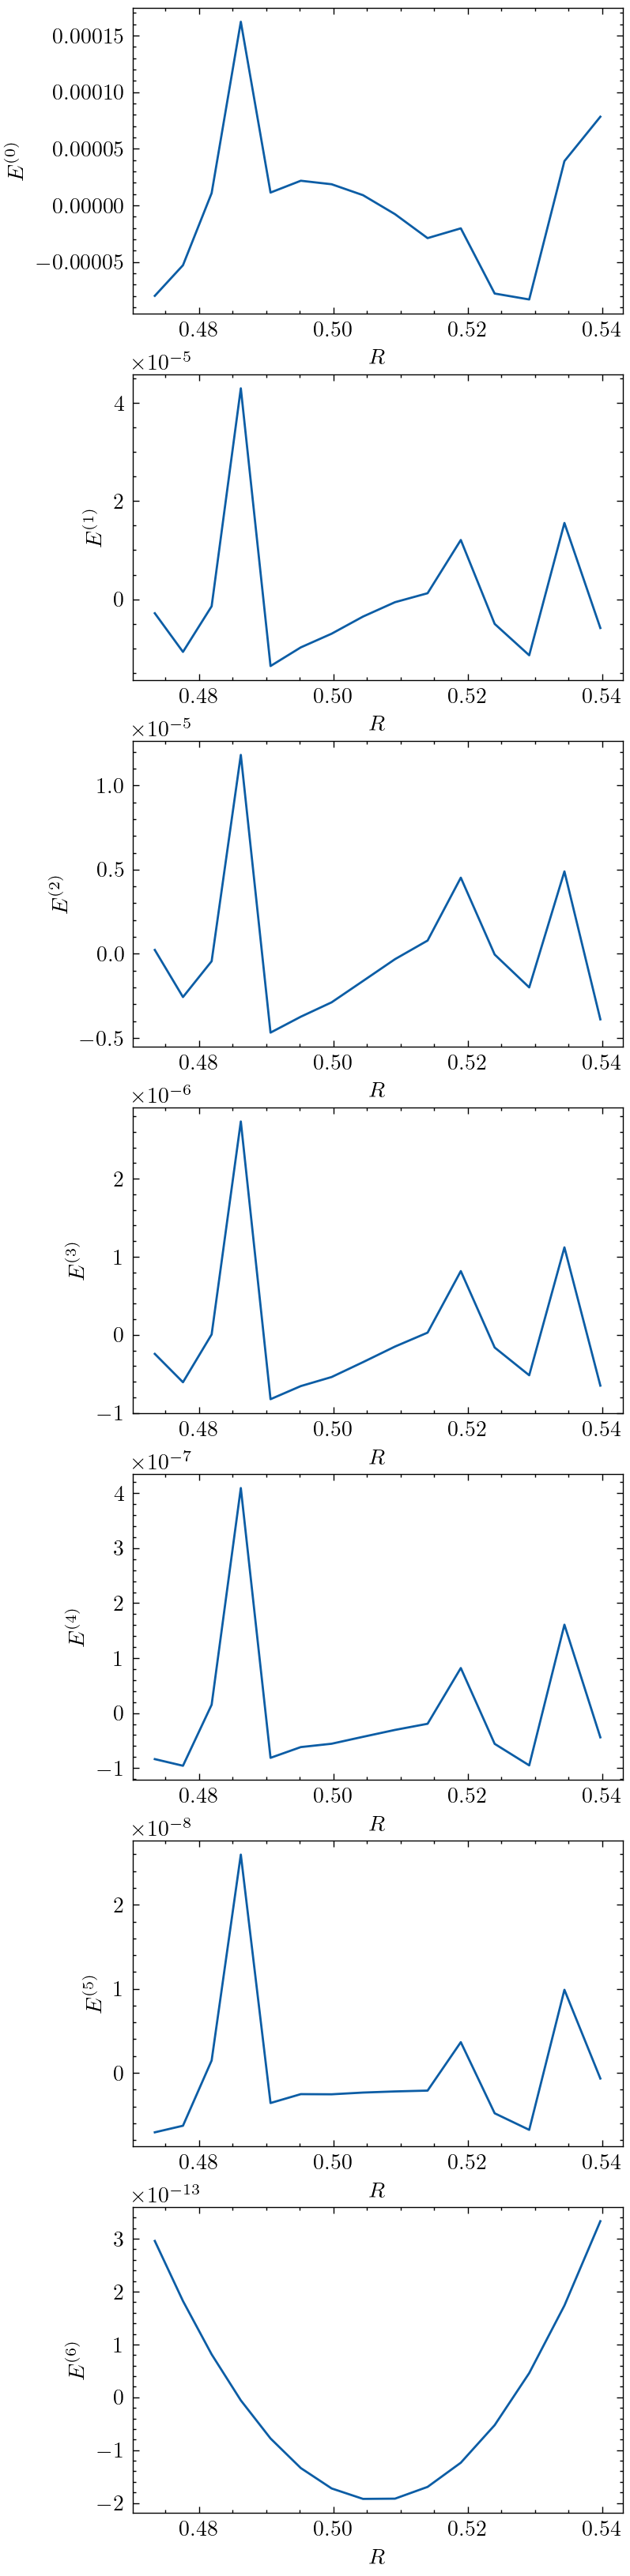

In [44]:
fig, ax = plt.subplots(7, figsize=(4, 7*3), dpi=200)
fig.patch.set_facecolor('white')

first = True
for (i, row) in enumerate(energies_nlo[:, ii]):
    converged = False
    while not converged:
        guess = [row[-1]] + num_coeffs*[10*np.random.rand()-5]
#         guess = [row[-1], 10*np.random.rand()-5]
        pars, cov, infodict, msg, ier = optimize.curve_fit(
            f, x_nlo[ii], row, p0=guess, maxfev=1000000, full_output=True,
            sigma=0.1*np.abs(np.mean(row))*np.ones(row.size)
        )
        err = np.sqrt(np.sum(np.array(infodict['fvec'])**2))
        converged = err < 1
#         print(guess, err)
        os.system('clear')
    
    print(pars)
    first = False
    sigma = np.sqrt(np.diag(cov))
    guess = pars
#     ax[i].plot(const.BETA4/x_nlo[ii], row - pars[0]*pars[1]/x_nlo[ii] - pars[0]*pars[2]/x_nlo[ii]**4)
    ax[i].plot(const.BETA4/x_nlo[ii], row - f(x_nlo[ii], *pars))
    
    xp = np.linspace(x_nlo[ii][0], 5*x_nlo[ii][-1], 100)
#     ax[i].plot(const.BETA4/xp, convergence12(xp, *pars), linestyle='--')
    
#     ax[i].axhline(pars[0], color='C6')
    
    ax[i].set_xlabel(r'$R$')
    ax[i].set_ylabel(r'$E^{(%d)}$' % (i))
#     ax[i].set_yscale('log');

In [45]:
def read_slope(x, y):
    x1, x2 = x[[-1, 0]]
    y1, y2 = y[[-1, 0]]
    print(x1, y1)
    print(x2, y2)
    m = (y2-y1) / (x2-x1)
    b = y2 - m*x2
    return m, b

In [46]:
lo_asymp / mm - 1

array([ 3.59649934,  2.37781561,  1.49736696,  0.85855373,  0.40508504,
        0.11828287, -0.00715512])

In [47]:
nlo_asymp[:-1] / mm[:-1] - 1

array([-1.17245545e+01, -5.15800175e+00, -2.10111029e+00, -6.64995743e-01,
       -1.19087816e-01, -4.88382896e-03])

In [48]:
pars_lo = read_slope(np.log(2*const.MU*(-mm)*const.BETA4**2),
                     np.log(np.abs(np.array(lo_asymp) / mm - 1)))
pars_nlo = read_slope(np.log(2*const.MU*(-mm[3:-1])*const.BETA4**2),
                      np.log(np.abs(np.array(nlo_asymp[3:-1]) / mm[3:-1] - 1)))

4.113587978724772 -4.939927620982728
10.402727091681735 1.2799609656606314
6.678801941898997 -5.321825743863179
8.917273414222773 -0.40797464043109544


In [49]:
pars_nlo[0] / pars_lo[0]

2.2196220186739772

In [50]:
xs = np.linspace(60, 3e4, 1000)

In [51]:
pars_lo, pars_nlo

((0.9889888703255216, -9.008220349046386),
 (2.1951814727980308, -19.98300802720737))

In [52]:
nlo_asymp

[0.6945320036694779,
 0.18389813018842255,
 0.03017826262778509,
 -0.004911781001597987,
 -0.005387932538537453,
 -0.001555631197342802,
 -0.0001202456083612158]

In [53]:
mm

array([-0.06476092, -0.04422753, -0.02740712, -0.01466185, -0.00611631,
       -0.00156327, -0.00012022])

In [54]:
ratios_asymp = np.loadtxt('ratios_asymp.txt')

In [55]:
mm[-1]/lo_asymp[-1] - 1

0.007206680873162341

In [56]:
nlo_asymp_R4 = np.array(lo_asymp) * (1 + (mm[-1]/lo_asymp[-1] - 1) * ratios_asymp)

In [57]:
for (x, y, z) in zip(lo_asymp, nlo_asymp, nlo_asymp_R4):
    print(x, y, z)

-0.29767352176813383 0.6945320036694779 -0.9849333759702635
-0.14939242753297324 0.18389813018842255 -0.3475729407474697
-0.06844563750453793 0.03017826262778509 -0.1194196728326071
-0.027249829468125975 -0.004911781001597987 -0.03777136502038121
-0.008593936571172708 -0.005387932538537453 -0.010089809019310619
-0.0017481734997854684 -0.001555631197342802 -0.0018405896824063533
-0.00011935922586892024 -0.0001202456083612158 -0.00012023466914125028


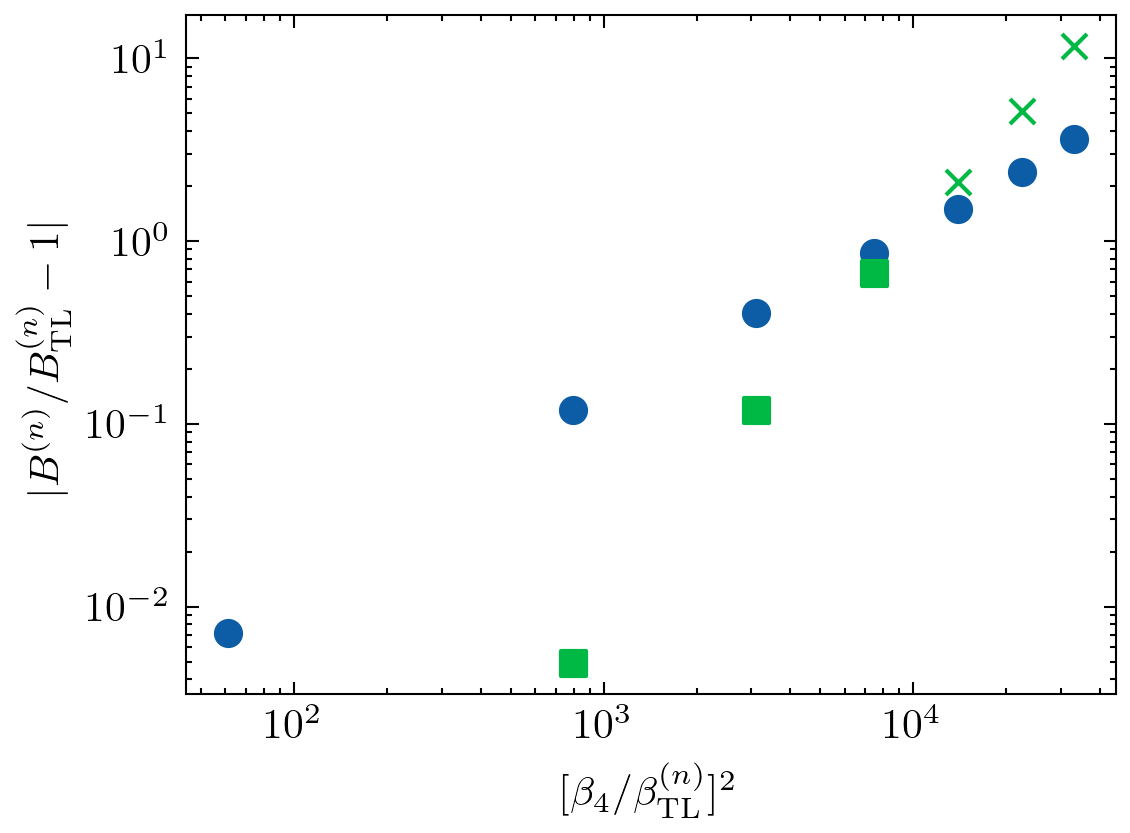

In [59]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
fig.patch.set_facecolor('white')

ax.scatter(2*const.MU*(-mm)*const.BETA4**2, np.abs(-np.array(lo_asymp) / -mm - 1))
ax.scatter(2*const.MU*(-mm[3:-1])*const.BETA4**2, np.abs(-np.array(nlo_asymp[3:-1]) / -mm[3:-1] - 1), marker='s')
ax.scatter(2*const.MU*(-mm[:-4])*const.BETA4**2, np.abs(np.array(nlo_asymp[:-4]) / mm[:-4] - 1), marker='x',
           color='C1')
# ax.scatter(2*const.MU*(-mm[:-1])*const.BETA4**2, np.abs(np.array(nlo_asymp_R4[:-1]) / mm[:-1] - 1), marker='s')

# ax.plot(xs, pars_lo[0]*xs + pars_lo[1])
# ax.plot(np.exp(xs), pars_nlo[0]*xs + pars_nlo[1])

ax.set_xlabel(r'$[\beta_4/\beta^{(n)}_{\rm TL}]^2$')
ax.set_ylabel(r'$|B^{(n)}/B^{(n)}_{\rm TL} - 1|$')

ax.set_xscale('log')
ax.set_yscale('log');

plt.savefig('figures/lo_nlo_error.pdf')

# ax.set_xlim([]);

In [61]:
list(range(6, -1, -1))

[6, 5, 4, 3, 2, 1, 0]

In [62]:
for (i, lo, nlo, x) in zip(range(6, -1, -1), lo_asymp[::-1], nlo_asymp[::-1], mm[::-1]):
    print(f'{i} & {-lo:.2e} & {-nlo:.2e} & {-x:.2e} \\\\')
    print('\\hline')

6 & 1.19e-04 & 1.20e-04 & 1.20e-04 \\
\hline
5 & 1.75e-03 & 1.56e-03 & 1.56e-03 \\
\hline
4 & 8.59e-03 & 5.39e-03 & 6.12e-03 \\
\hline
3 & 2.72e-02 & 4.91e-03 & 1.47e-02 \\
\hline
2 & 6.84e-02 & -3.02e-02 & 2.74e-02 \\
\hline
1 & 1.49e-01 & -1.84e-01 & 4.42e-02 \\
\hline
0 & 2.98e-01 & -6.95e-01 & 6.48e-02 \\
\hline


In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(2*4, 4*3), dpi=200)
fig.patch.set_facecolor('white')
fig.delaxes(ax[3, 1])

num_pts = 10
stop = np.argmin(np.abs(const.BETA4/nlo[:, 0] - 70)) + 1

for k in range(7):
    i = k//2
    j = k%2
#     ax[i, j].plot(const.BETA4/lo[stop-num_pts:stop, 0], lo[stop-num_pts:stop, k+1], label=r'$E^{({\rm LO})}(R)$')
    ax[i, j].plot(const.BETA4/nlo[stop-num_pts:stop, 0], nlo[stop-num_pts:stop, k+1],
                  label=r'$E^{({\rm NLO})}(R)$', marker='o', linestyle='')
#     ax[i, j].axhline(mm[k], linestyle='--', color='C6', label='MM')
    
    par, cov = optimize.curve_fit(convergence, const.BETA4/lo[stop-num_pts:stop, 0], lo[stop-num_pts:stop, k+1])
#     ax[i, j].axhline(par[0], color='C0', linestyle='--', label=r'$E_\infty^{({\rm LO})}$')
#     ax[i, j].plot(const.BETA4/lo[stop-num_pts:stop, 0], convergence(const.BETA4/lo[stop-num_pts:stop, 0], *par),
#                   linestyle='--', label='LO fit')
    lo_asymp[k] = par[0]
    
    par, cov = optimize.curve_fit(convergence12, 
                                  const.BETA4/nlo[stop-num_pts:stop, 0], 
                                  nlo[stop-num_pts:stop, k+1],
                                  p0=[1, 1, 1],
                                  maxfev=3000)
#     ax[i, j].axhline(par[0], color='C1', linestyle='--', label=r'$E_\infty^{({\rm NLO})}$')
    y_nlo = nlo[stop-num_pts:stop, k+1]
    mu_nlo = convergence12(const.BETA4/nlo[stop-num_pts:stop, 0], *par)
    print(f'{np.sum((y_nlo - mu_nlo)**2) / (num_pts - par.size):.2e}')
    ax[i, j].plot(const.BETA4/lo[stop-num_pts:stop, 0], mu_nlo,
                  linestyle='--', label='NLO fit')
    nlo_asymp[k] = par[0]
    
    ax[i, j].set_ylabel(r'$E_{n=%d}$' % (k))
    ax[i, j].set_xlabel(r'$\beta_4/R$')
    if k == 6:
        ax[i, j].legend()
    
#     f = interp1d(const.BETA4/lo[-num_pts:, 0], lo[-num_pts:, k+1], kind='cubic', fill_value='extrapolate')
#     ax[i, j].scatter(50, f(50))
    
#     g = interp1d(const.BETA4/nlo[-num_pts:, 0], nlo[-num_pts:, k+1], kind='cubic', fill_value='extrapolate')
#     ax[i, j].scatter(50, g(50))
    

$$\sum_i (y_i - \mu_i)^2 / \nu $$

| Quadratic | Both |
| --------- | ---- |
| 7.91e-07  | 6.01e-07 |
| 6.15e-08  | 6.29e-08 |
| 3.97e-08  | 1.94e-08 |
| 1.12e-08  | 2.17e-09 |
| 4.38e-10  | 5.35e-11 |
| 2.39e-12  | 2.24e-13 |
| 2.77e-26  | 9.01e-27 |

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
fig.patch.set_facecolor('white')

num_pts = 34
stop = np.argmin(np.abs(const.BETA4/lo[:, 0] - 30)) + 1

for k in range(7):
    i = k//2
    j = k%2
    ax.plot(const.BETA4/lo[stop-num_pts:stop, 0], -lo[stop-num_pts:stop, k+1], label=r'$E^{({\rm LO})}(R)$',
            color='C0')
    ax.plot(const.BETA4/nlo[stop-num_pts:stop, 0], -nlo[stop-num_pts:stop, k+1], label=r'$E^{({\rm NLO})}(R)$',
            color='C1', linestyle='-.')
    ax.axhline(-mm[k], linestyle='--', color='C6', label='MM')
    ax.set_yscale('log')
#     par, cov = optimize.curve_fit(convergence, const.BETA4/lo[stop-num_pts:stop, 0], lo[stop-num_pts:stop, k+1])
#     ax[i, j].axhline(par[0], color='C0', linestyle='--', label=r'$E_\infty^{({\rm LO})}$')
#     ax[i, j].plot(const.BETA4/lo[stop-num_pts:stop, 0], convergence(const.BETA4/lo[stop-num_pts:stop, 0], *par),
#                   linestyle='--', label='LO fit')
#     lo_asymp[k] = par[0]
    
#     par, cov = optimize.curve_fit(convergence2, const.BETA4/nlo[stop-num_pts:stop, 0], nlo[stop-num_pts:stop, k+1])
#     ax[i, j].axhline(par[0], color='C1', linestyle='--', label=r'$E_\infty^{({\rm NLO})}$')
#     ax[i, j].plot(const.BETA4/lo[stop-num_pts:stop, 0], convergence2(const.BETA4/lo[stop-num_pts:stop, 0], *par),
#                   linestyle='--', label='NLO fit')
#     nlo_asymp[k] = par[0]
    
    ax.set_ylabel(r'$B_{n}$')
    ax.set_xlabel(r'$\beta_4/R$ (a.u.)')
#     if k == 6:
#         ax[i, j].legend()
    
#     f = interp1d(const.BETA4/lo[-num_pts:, 0], lo[-num_pts:, k+1], kind='cubic', fill_value='extrapolate')
#     ax[i, j].scatter(50, f(50))
    
#     g = interp1d(const.BETA4/nlo[-num_pts:, 0], nlo[-num_pts:, k+1], kind='cubic', fill_value='extrapolate')
#     ax[i, j].scatter(50, g(50))

# plt.savefig('figures/lo_nlo_spectrum_R.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
fig.patch.set_facecolor('white')

num_pts = 34
stop = np.argmin(np.abs(const.BETA4/lo[:, 0] - 30)) + 1

for k in range(7):
    i = k//2
    j = k%2
    ax.plot(const.BETA4/lo[stop-num_pts:stop, 0], -lo[stop-num_pts:stop, k+1], label=r'$E^{({\rm LO})}(R)$',
            color='C0')
    ax.plot(const.BETA4/nlo[stop-num_pts:stop, 0], -nlo[stop-num_pts:stop, k+1], label=r'$E^{({\rm NLO})}(R)$',
            color='C1', linestyle='-.')
    ax.axhline(-mm[k], linestyle='--', color='C6', label='MM')
    ax.set_yscale('log')
#     par, cov = optimize.curve_fit(convergence, const.BETA4/lo[stop-num_pts:stop, 0], lo[stop-num_pts:stop, k+1])
#     ax[i, j].axhline(par[0], color='C0', linestyle='--', label=r'$E_\infty^{({\rm LO})}$')
#     ax[i, j].plot(const.BETA4/lo[stop-num_pts:stop, 0], convergence(const.BETA4/lo[stop-num_pts:stop, 0], *par),
#                   linestyle='--', label='LO fit')
#     lo_asymp[k] = par[0]
    
#     par, cov = optimize.curve_fit(convergence2, const.BETA4/nlo[stop-num_pts:stop, 0], nlo[stop-num_pts:stop, k+1])
#     ax[i, j].axhline(par[0], color='C1', linestyle='--', label=r'$E_\infty^{({\rm NLO})}$')
#     ax[i, j].plot(const.BETA4/lo[stop-num_pts:stop, 0], convergence2(const.BETA4/lo[stop-num_pts:stop, 0], *par),
#                   linestyle='--', label='NLO fit')
#     nlo_asymp[k] = par[0]
    
    ax.set_ylabel(r'$B_{n}$')
    ax.set_xlabel(r'$\beta_4/R$ (a.u.)')
#     if k == 6:
#         ax[i, j].legend()
    
#     f = interp1d(const.BETA4/lo[-num_pts:, 0], lo[-num_pts:, k+1], kind='cubic', fill_value='extrapolate')
#     ax[i, j].scatter(50, f(50))
    
#     g = interp1d(const.BETA4/nlo[-num_pts:, 0], nlo[-num_pts:, k+1], kind='cubic', fill_value='extrapolate')
#     ax[i, j].scatter(50, g(50))

# plt.savefig('figures/lo_nlo_spectrum_R.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
fig.patch.set_facecolor('white')

ax.scatter(lo_asymp, nlo_asymp - lo_asymp)

ax.set_xlabel(r'$E_{\rm LO}$')
ax.set_ylabel(r'$\Delta_{\rm NLO}$');

In [ ]:
for (e_lo, e_nlo, e_mm) in zip(lo_asymp[::-1], nlo_asymp[::-1], mm[::-1]):
    print(r'%.2e & %.2e & %.2e \\' % (-e_mm, -e_lo, -e_nlo))

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
fig.patch.set_facecolor('white')

ax.scatter(mm, (mm - lo_asymp)/mm)
ax.scatter(mm, (mm - nlo_asymp)/mm)
# ax.axvline(-1/(2*const.MU*5**2))

ax.set_xlabel(r'$E_{\rm MM}$')
ax.set_ylabel(r'$(E_{\rm MM} - E_{\rm id})/E_{\rm MM}$');

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
fig.patch.set_facecolor('white')

ax.plot(np.abs(mm), np.abs((mm - lo_asymp)/mm), marker='o', linestyle='', label='LO')
# ax.loglog(np.abs(mm[:-1]), np.abs((mm[:-1] - nlo_asymp[:-1])/mm[:-1]), marker='o', linestyle='', label='NLO')
# ax.axvline(-1/(2*const.MU*5**2))

# ax.legend()
ax.set_xlabel(r'$B_{\rm MM}$')
ax.set_ylabel(r'$\left( B_{\rm MM} - B_{\rm id} \right)/B_{\rm MM}$');

# plt.savefig('figures/lo_error.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
fig.patch.set_facecolor('white')

ax.loglog(np.abs(mm), np.abs((mm - lo_asymp)/mm), marker='o', linestyle='', label='LO')
ax.loglog(np.abs(mm[:-1]), np.abs((mm[:-1] - nlo_asymp[:-1])/mm[:-1]), marker='o', linestyle='', label='NLO')
# ax.axvline(-1/(2*const.MU*5**2))

ax.legend()
ax.set_xlabel(r'$B_{\rm MM}$')
ax.set_ylabel(r'$(B_{\rm MM} - B_{\rm id})/B_{\rm MM}$');

In [ ]:
par_lo, cov_lo = optimize.curve_fit(lambda x, m, b: m*x+b,
                                    np.log(np.abs(mm)),
                                    np.log(np.abs((mm - lo_asymp)/mm)))
par_lo

In [ ]:
par_nlo, cov_nlo = optimize.curve_fit(lambda x, m, b: m*x+b,
                              np.log(np.abs(mm[2:-1])),
                              np.log(np.abs((mm[2:-1] - nlo_asymp[2:-1])/mm[2:-1]))
                             )
par_nlo

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
fig.patch.set_facecolor('white')

ax.scatter(np.abs(mm), np.abs((mm - lo_asymp)/mm), marker='o', label='LO')
ax.scatter(np.abs(mm[:-1]), np.abs((mm[:-1] - nlo_asymp[:-1])/mm[:-1]), marker='s', label='NLO')
# ax.axvline(-1/(2*const.MU*5**2))

xs = np.linspace(np.log(np.abs(mm)[0]), np.log(np.abs(mm)[-1]), 100)
ax.plot(np.exp(xs), np.exp(par_lo[0]*xs + par_lo[1]), color='C0', linestyle='-')
ax.plot(np.exp(xs), np.exp(par_nlo[0]*xs + par_nlo[1]), color='C1', linestyle='-.')

ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$B_{\rm TL}$')
ax.set_ylabel(r'$(B_{\rm TL} - B_{\rm id})/B_{\rm TL}$');

# plt.savefig('figures/lo_nlo_error_loglog.pdf')